In [1]:
"""
This notebook generates ISM shuffle plots for the subset of the randoms that are CpG islands (Fig. 7F).
"""

'\nThis notebook generates ISM shuffle plots for the subset of the randoms that are CpG islands (Fig. 7F).\n'

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pybedtools

In [3]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set SCRATCH to where you want to download data to
SCRATCH = "/Users/adamhe/github/SCRATCH"

URL = "https://zenodo.org/records/10597358/files"
TAR = "mutagenesis.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -cvzf {SCRATCH}/{TAR}")

wget https://zenodo.org/records/10597358/files/mutagenesis.tar.gz -P /Users/adamhe/github/SCRATCH
tar -cvzf /Users/adamhe/github/SCRATCH/mutagenesis.tar.gz


In [4]:
# Load data

motif = "random"
# Load ISM scores
ism_shuffle_scores = np.load(
    os.path.join(SCRATCH, f"mutagenesis/{motif}/ensemble_ism_shuffle_{motif}_oriented.npz")
)
corr = ism_shuffle_scores["corr_ism_shuffle"]
log_quantity = ism_shuffle_scores["log_quantity_ism_shuffle"]

# Load TSS positions
pred = np.load(os.path.join(SCRATCH, f"mutagenesis/{motif}/{motif}_oriented_prediction.npz"))
pred_tss = np.argmax(np.array(pred["track"])[:, :500], axis=1)
center = pred_tss + 250 - 50

# Extract ISM shuffle scores around TSS
corr_around_tss = np.array(
    [corr[i, center[i] - 200:center[i] + 200] for i in range(len(center))]
)
log_quantity_around_tss = np.array(
    [log_quantity[i, center[i] - 200:center[i] + 200] for i in range(len(center))]
)

In [6]:
# Load TATA-containing sequence windows so we can exclude them
random_bed = pybedtools.BedTool(
    os.path.join(SCRATCH, f"mutagenesis/{motif}/merged_windows_{motif}.bed.gz")
)
tata_bed = pybedtools.BedTool(
    os.path.join(SCRATCH, "mutagenesis/tata/active_full_length_tata_tss_windows.bed.gz")
)
tataless = random_bed.intersect(tata_bed, v=True)

# Load CpG island data (CpG fraction of expected > 0.6, GC > 0.5)
cpg = pd.read_csv(os.path.join(SCRATCH, f"mutagenesis/{motif}/{motif}_tss_windows_reference_seq_cpg.csv.gz"))

# Get TATAless CpG island indices:
cpg_tataless_idx = [
    i for i in range(len(random_bed)) if cpg["CpG_island"][i] and random_bed[i] in tataless
]

# Filter records for tataless and tataless CpG
corr_around_tss_cpg = corr_around_tss[cpg_tataless_idx]
log_quantity_around_tss_cpg = log_quantity_around_tss[cpg_tataless_idx]

In [9]:
# Coerce to shape required for seaborn lineplot

corr_2d = pd.DataFrame(
    {
        "pos": list(range(-200, 200)) * corr_around_tss_cpg.shape[0],
        "corr": corr_around_tss_cpg.reshape(
            corr_around_tss_cpg.shape[0] * corr_around_tss_cpg.shape[1],
        ),
    }
)
log_quantity_2d = pd.DataFrame(
    {
        "pos": list(range(-200, 200)) * log_quantity_around_tss_cpg.shape[0],
        "quantity": log_quantity_around_tss_cpg.reshape(
            log_quantity_around_tss_cpg.shape[0] * log_quantity_around_tss_cpg.shape[1],
        ),
    }
)

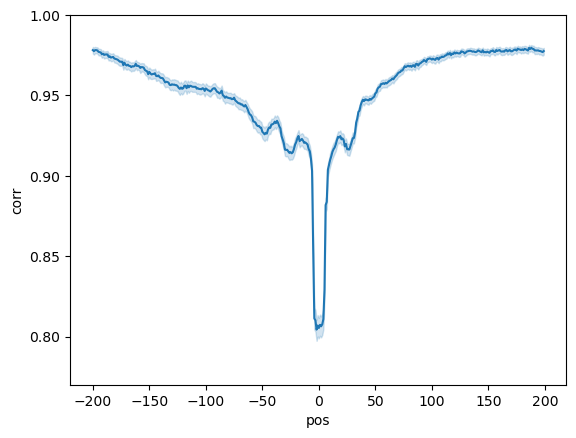

In [10]:
# Plot ISM shuffle correlation effect

ax = sns.lineplot(data=corr_2d, x="pos", y="corr")
plt.ylim(0.77, 1)
plt.savefig("img/cpg_ism_shuffle_corr.pdf")

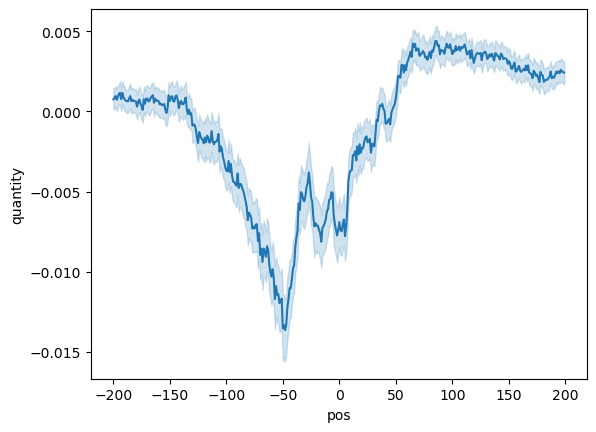

In [11]:
# Plot ISM shuffle log quantity effect

ax = sns.lineplot(data=log_quantity_2d, x="pos", y="quantity")
plt.savefig("img/cpg_ism_shuffle_log_quantity.pdf")